## LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import types
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.readwrite import ProbModelXMLWriter, get_probmodel_data
from pgmpy.sampling import BayesianModelSampling
from pgmpy.sampling import GibbsSampling
from pgmpy.inference import VariableElimination
import time 
import networkx as nx
import matplotlib.pyplot as plt 
from pgmpy.estimators import HillClimbSearch

## DATASET

In [2]:
mp =  pd.read_csv("Table2.csv")
cpd_x1 = pd.read_csv("Table3.csv")
cpd_x2 = pd.read_csv("Table4.csv")
cpd_x3 = pd.read_csv("Table5.csv")
cpd_x4 = pd.read_csv("Table6.csv")
cpd_x5 = pd.read_csv("Table7.csv")
cpd_x6 = pd.read_csv("Table8.csv")
#print(mp.shape)
#print(cpd_x1.shape)


In [3]:
mp

,Values,x1 (Relative height to t to h),x2 (Shape of h loop),x3 (Shape of h arch),x4 (Height of Cross ),x5 (Baseline of h),x6 (Shape of t)
0,a = x0,78% (156),27.5%(55),18%(36),71.5%(143),37.5%(75),1.5%(3)
1,b = x1,1.5%(3),32%(64),66%(132),10.5%(21),11%(22),32%(64)
2,c = x2,5.5%(11),2.5% (5),16%(32),1%(2),10.5%(21),14%(28)
3,d = x3,15%(30),17%(34),NaN,17%(34),41%(82),31.5%(63)
4,e = x4,NaN,21%(42),NaN,NaN,NaN,21%(42)


## FUNCTIONS


In [4]:
def split_Data(dataset):
    M = np.zeros((dataset.shape))
    for row in range(0,dataset.shape[0]):
        for column in range(1,dataset.shape[1]):
            if (isinstance(dataset.iloc[row][column],str)):
                Total_prob = int(dataset.iloc[0][column].split('(', 1)[1].split(')')[0])
                temp = dataset.iloc[row][column]
                split_data = temp.split('(', 1)[1].split(')')[0]
                if (row != 0):
                    M[row][column] = (int(split_data)/Total_prob)
                else:
                    t = dataset.iloc[row][column].split("%")
                    M[row][column] =  float(t[0])/100 
            else:
                #print(M[row][column],"is empty")
                M[row][column] =0
              
    M = M[0:,1:]
    return M

def Joint_Probability(dataset):
    Joint = np.multiply(dataset[1:],dataset[0])
    return Joint



In [5]:
def product(dataset,MarginalSet,code):
    Vector_col =[]
    dataset_temp = dataset
    new = dataset_temp[code].str.split(" ",n=1,expand=True)
    new1 = new[0].str.split("x",n=1,expand=True)
    dataset_temp["mp_row"] = new1[1]
    for row in range (1,dataset_temp.shape[0]):
        s = dataset_temp.iloc[row][dataset_temp.shape[1]-1]
        a,b =[int(d) for d in str(s)]
        Vector_col.append(float((MarginalSet.iloc[a][b].split("%"))[0])/100)
    Vector_row = ((dataset.iloc[0].str.split("%",n=1,expand=True))[0])
    Vector_row = Vector_row[(len(Vector_row)-len(Vector_row)+1):len(Vector_row)-1,]
    Vector_rr=(Vector_row.tolist())
    Vector_row1=[float(d)/100 for d in (Vector_rr)]
    Matrix = np.zeros((len(Vector_col),len(Vector_row1)))
    for i in range (0,len(Vector_col)):
        for j in range(0,len(Vector_row1)):
            Matrix[i][j] = (Vector_col[i]*Vector_row1[j])
    return Matrix

In [6]:
def summation(dataset,l):
    sum_temp1 =[]
    for i in range(0,len(l)):
        for j in range(0,1):
            sum_2 = np.sum(dataset[l[i][j]:l[i][j+1]],axis=1)
            sum_temp1.append(abs(np.sum(sum_2,axis=0)))
        
    return sum_temp1

In [7]:
def adding_cpd(dataset,l,code):
    cpd_temp =[]
    for i in range(0,len(l)):
        for j in range(0,1):
            m = (dataset[l[i][j]:l[i][j+1]])
            #m = np.transpose(m)
            #m = m/m.sum(axis=1,keepdims=1)
            cpd = TabularCPD(code[i][j+1],m.shape[0],m,evidence=[code[i][j]], evidence_card=[m.shape[1]])
            cpd_temp.append(cpd)
    return cpd_temp

## CALLING FUCNTIONS

In [8]:
#marginal = split_Data(mp)
conditional_x1 = split_Data(cpd_x1)
#conditional_x1 = conditional_x1[1:,]
conditional_x2 = split_Data(cpd_x2)
conditional_x3 = split_Data(cpd_x3)
conditional_x4 = split_Data(cpd_x4)
conditional_x5 = split_Data(cpd_x5)
conditional_x6 = split_Data(cpd_x6)
joint_x1       = Joint_Probability(conditional_x1)
joint_x2       = Joint_Probability(conditional_x2)
joint_x3       = Joint_Probability(conditional_x3)
joint_x4       = Joint_Probability(conditional_x4)
joint_x5       = Joint_Probability(conditional_x5)
joint_x6       = Joint_Probability(conditional_x6) 


In [9]:
conditional_x1

array([[0.78      , 0.015     , 0.055     , 0.15      ],
       [0.23076923, 0.66666667, 0.45454545, 0.4       ],
       [0.36538462, 0.        , 0.09090909, 0.2       ],
       [0.02564103, 0.        , 0.        , 0.03333333],
       [0.17307692, 0.        , 0.18181818, 0.16666667],
       [0.20512821, 0.33333333, 0.27272727, 0.2       ],
       [0.73717949, 1.        , 0.72727273, 0.56666667],
       [0.07692308, 0.        , 0.27272727, 0.2       ],
       [0.01282051, 0.        , 0.        , 0.        ],
       [0.17307692, 0.        , 0.        , 0.23333333],
       [0.01923077, 0.        , 0.        , 0.        ],
       [0.28205128, 0.66666667, 0.54545455, 0.4       ],
       [0.12820513, 0.33333333, 0.09090909, 0.2       ],
       [0.3525641 , 0.        , 0.18181818, 0.2       ],
       [0.21794872, 0.        , 0.18181818, 0.2       ]])

In [10]:
joint_x1

array([[0.18 , 0.01 , 0.025, 0.06 ],
       [0.285, 0.   , 0.005, 0.03 ],
       [0.02 , 0.   , 0.   , 0.005],
       [0.135, 0.   , 0.01 , 0.025],
       [0.16 , 0.005, 0.015, 0.03 ],
       [0.575, 0.015, 0.04 , 0.085],
       [0.06 , 0.   , 0.015, 0.03 ],
       [0.01 , 0.   , 0.   , 0.   ],
       [0.135, 0.   , 0.   , 0.035],
       [0.015, 0.   , 0.   , 0.   ],
       [0.22 , 0.01 , 0.03 , 0.06 ],
       [0.1  , 0.005, 0.005, 0.03 ],
       [0.275, 0.   , 0.01 , 0.03 ],
       [0.17 , 0.   , 0.01 , 0.03 ]])

In [11]:
prod_x1       = product(cpd_x1,mp,'x1')
prod_x2       = product(cpd_x2,mp,'x2')
prod_x3       = product(cpd_x3,mp,'x3')
prod_x4       = product(cpd_x4,mp,'x4')
prod_x5       = product(cpd_x5,mp,'x5')
prod_x6       = product(cpd_x6,mp,'x6')

In [12]:
prod_x1

array([[2.1450e-01, 4.1250e-03, 1.5125e-02, 4.1250e-02],
       [2.4960e-01, 4.8000e-03, 1.7600e-02, 4.8000e-02],
       [1.9500e-02, 3.7500e-04, 1.3750e-03, 3.7500e-03],
       [1.3260e-01, 2.5500e-03, 9.3500e-03, 2.5500e-02],
       [1.6380e-01, 3.1500e-03, 1.1550e-02, 3.1500e-02],
       [5.5770e-01, 1.0725e-02, 3.9325e-02, 1.0725e-01],
       [8.1900e-02, 1.5750e-03, 5.7750e-03, 1.5750e-02],
       [7.8000e-03, 1.5000e-04, 5.5000e-04, 1.5000e-03],
       [1.3260e-01, 2.5500e-03, 9.3500e-03, 2.5500e-02],
       [1.1700e-02, 2.2500e-04, 8.2500e-04, 2.2500e-03],
       [2.4960e-01, 4.8000e-03, 1.7600e-02, 4.8000e-02],
       [1.0920e-01, 2.1000e-03, 7.7000e-03, 2.1000e-02],
       [2.4570e-01, 4.7250e-03, 1.7325e-02, 4.7250e-02],
       [1.6380e-01, 3.1500e-03, 1.1550e-02, 3.1500e-02]])

In [13]:
diff_x1 = (joint_x1 - prod_x1)
diff_x2 = (joint_x2 - prod_x2)
diff_x3 = (joint_x3 - prod_x3)
diff_x4 = (joint_x4 - prod_x4)
diff_x5 = (joint_x5 - prod_x5)
diff_x6 = (joint_x6 - prod_x6)

In [14]:
#print(diff_x1.shape == joint_x1.shape)
#print(diff_x2.shape == joint_x2.shape)
#print(diff_x3.shape == joint_x3.shape)
#print(diff_x4.shape == joint_x4.shape)
#print(diff_x5.shape == joint_x5.shape)
diff_x1

array([[-0.0345  ,  0.005875,  0.009875,  0.01875 ],
       [ 0.0354  , -0.0048  , -0.0126  , -0.018   ],
       [ 0.0005  , -0.000375, -0.001375,  0.00125 ],
       [ 0.0024  , -0.00255 ,  0.00065 , -0.0005  ],
       [-0.0038  ,  0.00185 ,  0.00345 , -0.0015  ],
       [ 0.0173  ,  0.004275,  0.000675, -0.02225 ],
       [-0.0219  , -0.001575,  0.009225,  0.01425 ],
       [ 0.0022  , -0.00015 , -0.00055 , -0.0015  ],
       [ 0.0024  , -0.00255 , -0.00935 ,  0.0095  ],
       [ 0.0033  , -0.000225, -0.000825, -0.00225 ],
       [-0.0296  ,  0.0052  ,  0.0124  ,  0.012   ],
       [-0.0092  ,  0.0029  , -0.0027  ,  0.009   ],
       [ 0.0293  , -0.004725, -0.007325, -0.01725 ],
       [ 0.0062  , -0.00315 , -0.00155 , -0.0015  ]])

In [15]:
l1 = [[0,5],[5,9],[9,14]]
corelation_x1 = summation(abs(diff_x1),l1)
l2 = [[0,3],[3,7]]
corelation_x2 = summation(abs(diff_x2),l2)
l3 = [[0,5],[5,9],[9,14]]
corelation_x3 = summation(abs(diff_x3),l3)
l4 = [[0,4],[4,9],[9,14]]
corelation_x4 = summation(abs(diff_x4),l4)
l5 = [[0,5],[5,8]]
corelation_x5 = summation(abs(diff_x5),l5)
l6 = [[0,4],[4,9],[9,12],[12,16]]
corelation_x6 = summation(abs(diff_x6),l6)
print("correlation [x2,x4,x6|x1]"   ,corelation_x1)
print("correlation [x3,x5|x2]"      ,corelation_x2)
print("correlation [x2,x5,x6|x3]"   ,corelation_x3)
print("correlation [x1,x2,x6|x4]"   ,corelation_x4)
print("correlation [x2,x3|x5]"      ,corelation_x5)
print("correlation [x1,x2,x3,x4|x6]",corelation_x6)

correlation [x2,x4,x6|x1] [0.15999999999999995, 0.11965000000000006, 0.16060000000000008]
correlation [x3,x5|x2] [0.21820000000000006, 0.12935]
correlation [x2,x5,x6|x3] [0.2982, 0.1156, 0.09479999999999997]
correlation [x1,x2,x6|x4] [0.11964999999999998, 0.11569999999999998, 0.14319999999999997]
correlation [x2,x3|x5] [0.3690499999999999, 0.11560000000000001]
correlation [x1,x2,x3,x4|x6] [0.16660000000000003, 0.1749, 0.09480000000000005, 0.14320000000000002]


In [16]:
code1 = [['x1','x2'],['x1','x4'],['x1','x6']]
l1_1 =[[1,6],[6,10],[10,15]]
a_cpd_x1 = adding_cpd(conditional_x1,l1_1,code1)
code2 = [['x2','x3'],['x2','x5']]
l2_2 = [[1,4],[4,8]]
a_cpd_x2 = adding_cpd(conditional_x2,l2_2,code2)
code3 = [['x3','x2'],['x3','x5'],['x3','x6']]
l3_3 = [[1,6],[6,10],[10,15]]
a_cpd_x3 = adding_cpd(conditional_x3,l3_3,code3)
code4 = [['x4','x1'],['x4','x2'],['x4','x6']]
l4_4 = [[1,5],[5,10],[10,15]]
a_cpd_x4 = adding_cpd(conditional_x4,l4_4,code4)
code5 = [['x5','x2'],['x5','x3']]
l5_5 = [[1,6],[6,9]]
a_cpd_x5 = adding_cpd(conditional_x5,l5_5,code5)
code6 = [['x6','x1'],['x6','x2'],['x6','x3'],['x6','x4']]
l6_6 = [[1,5],[5,10],[10,13],[13,17]]
a_cpd_x6 = adding_cpd(conditional_x6,l6_6,code6)

In [17]:
cpd_x1_1 = TabularCPD(variable='x1',variable_card=4,values=[[0.78],[0.015],[0.055],[0.15]])
cpd_x2_1 = TabularCPD(variable='x2',variable_card=5,values=[[0.275],[0.32],[0.025],[0.17],[0.21]])
cpd_x3_1 = TabularCPD(variable='x3',variable_card=3,values=[[0.18],[0.66],[0.16]])
cpd_x4_1 = TabularCPD(variable='x4',variable_card=4,values=[[0.715],[0.105],[0.01],[0.17]])
cpd_x5_1 = TabularCPD(variable='x5',variable_card=4,values=[[0.375],[0.11],[0.105],[0.41]])
cpd_x6_1 = TabularCPD(variable='x6',variable_card=5,values=[[0.015],[0.32],[0.14],[0.315],[0.21]])

In [18]:
print(a_cpd_x1[0])

+------+---------------------+--------------------+---------------------+---------------------+
| x1   | x1_0                | x1_1               | x1_2                | x1_3                |
+------+---------------------+--------------------+---------------------+---------------------+
| x2_0 | 0.23076923076923078 | 0.6666666666666666 | 0.45454545454545453 | 0.4                 |
+------+---------------------+--------------------+---------------------+---------------------+
| x2_1 | 0.36538461538461536 | 0.0                | 0.09090909090909091 | 0.2                 |
+------+---------------------+--------------------+---------------------+---------------------+
| x2_2 | 0.02564102564102564 | 0.0                | 0.0                 | 0.03333333333333333 |
+------+---------------------+--------------------+---------------------+---------------------+
| x2_3 | 0.17307692307692307 | 0.0                | 0.18181818181818182 | 0.16666666666666666 |
+------+---------------------+----------

In [19]:
print(a_cpd_x3[2])

+------+---------------------+----------------------+---------+
| x3   | x3_0                | x3_1                 | x3_2    |
+------+---------------------+----------------------+---------+
| x6_0 | 0.0                 | 0.022727272727272728 | 0.0     |
+------+---------------------+----------------------+---------+
| x6_1 | 0.3888888888888889  | 0.3181818181818182   | 0.25    |
+------+---------------------+----------------------+---------+
| x6_2 | 0.08333333333333333 | 0.15151515151515152  | 0.15625 |
+------+---------------------+----------------------+---------+
| x6_3 | 0.3611111111111111  | 0.30303030303030304  | 0.3125  |
+------+---------------------+----------------------+---------+
| x6_4 | 0.16666666666666666 | 0.20454545454545456  | 0.28125 |
+------+---------------------+----------------------+---------+


#### ==========================================================================================================

### Rough

# TASK 2

### Defining the Models

In [20]:
## ====== Defining the Model 1 ==========
model_1 = BayesianModel()
model_1.add_nodes_from(['x1','x2','x3','x4','x5','x6'])
model_1.add_edges_from([('x1','x2'),('x1','x6'),('x1','x4'),('x2','x3'),('x2','x5')])
model_1.add_cpds(cpd_x1_1,a_cpd_x1[0],a_cpd_x1[1],a_cpd_x1[2],a_cpd_x2[0],a_cpd_x2[1])
print("===Model_1===")
print(model_1.get_cpds())
##======= Defining the Model 2 ==========
model_2 = BayesianModel()
model_2.add_nodes_from(['x1','x2','x3','x4','x5','x6'])
model_2.add_edges_from([('x6','x4'),('x4','x2'),('x4','x1'),('x2','x3'),('x3','x5')])
model_2.add_cpds(cpd_x6_1,a_cpd_x6[3],a_cpd_x4[1],a_cpd_x4[0],a_cpd_x2[0],a_cpd_x3[1])
print("===Model_2===")
model_2.get_cpds()
##======= Defining the Model 3 ==========
model_3 = BayesianModel()
model_3.add_nodes_from(['x1','x2','x3','x4','x5','x6'])
model_3.add_edges_from([('x1','x4'),('x1','x6'),('x4','x2'),('x2','x5'),('x5','x3')])
model_3.add_cpds(cpd_x1_1,a_cpd_x1[1],a_cpd_x1[2],a_cpd_x4[1],a_cpd_x2[1],a_cpd_x5[1])
print("===Model_3===")
model_3.get_cpds()
##======= Defining the Model 4 ==========
model_4 = BayesianModel()
model_4.add_nodes_from(['x1','x2','x3','x4','x5','x6'])
model_4.add_edges_from([('x4','x1'),('x1','x2'),('x1','x6'),('x2','x3'),('x3','x5')])
model_4.add_cpds(cpd_x4_1,a_cpd_x4[0],a_cpd_x1[0],a_cpd_x1[2],a_cpd_x2[0],a_cpd_x3[1])
print("===Model_4===")
model_4.get_cpds()
##====== Defining the Model 5 ===========
model_5 = BayesianModel()
model_5.add_nodes_from(['x1','x2','x3','x4','x5','x6'])
model_5.add_edges_from([('x6','x2'),('x6','x4'),('x2','x3'),('x2','x5'),('x4','x1')])
model_5.add_cpds(cpd_x6_1,a_cpd_x6[1],a_cpd_x6[3],a_cpd_x2[0],a_cpd_x2[1],a_cpd_x4[0])
print("===Model_5===")
model_5.get_cpds()
##====== getting the probability model ======
#model_data = get_probmodel_data(model_1)
#model_data

===Model_1===
[<TabularCPD representing P(x1:4) at 0x179f7e6e438>, <TabularCPD representing P(x2:5 | x1:4) at 0x179f7e6ec88>, <TabularCPD representing P(x4:4 | x1:4) at 0x179f7e6ecf8>, <TabularCPD representing P(x6:5 | x1:4) at 0x179f7e6ed30>, <TabularCPD representing P(x3:3 | x2:5) at 0x179f7e6eda0>, <TabularCPD representing P(x5:4 | x2:5) at 0x179f7e6ecc0>]
===Model_2===
===Model_3===
===Model_4===
===Model_5===


[<TabularCPD representing P(x6:5) at 0x179f7e6e828>,
 <TabularCPD representing P(x2:5 | x6:5) at 0x179f7e6efd0>,
 <TabularCPD representing P(x4:4 | x6:5) at 0x179f7e8e080>,
 <TabularCPD representing P(x3:3 | x2:5) at 0x179f7e6eda0>,
 <TabularCPD representing P(x5:4 | x2:5) at 0x179f7e6ecc0>,
 <TabularCPD representing P(x1:4 | x4:4) at 0x179f7e6edd8>]

In [21]:
#%matplotlib inline
#plt.figure(figsize=(5,5))
#G = nx.DiGraph(model_1)
#plt1 = nx.draw_networkx(G, with_labels=True, node_size= 2000,font_size= 20)


## Data Sampling 

In [22]:
## ==== Sampling the Data for Model_1 =====
inference_1 = BayesianModelSampling(model_1)
data_1 = inference_1.forward_sample(size=1000, return_type='dataframe')
## ==== Sampling the Data for Model_2 =====
inference_2 = BayesianModelSampling(model_2)
data_2 = inference_2.forward_sample(size=1000, return_type='dataframe')
## ==== Sampling the Data for Model_3 =====
inference_3 = BayesianModelSampling(model_3)
data_3 = inference_3.forward_sample(size=1000, return_type='dataframe')
## ==== Sampling the Data for Model_4 =====
inference_4 = BayesianModelSampling(model_4)
data_4 = inference_4.forward_sample(size=1000, return_type='dataframe')
## ==== Sampling the Data for Model_5 =====
inference_5 = BayesianModelSampling(model_5)
data_5 = inference_5.forward_sample(size=1000, return_type='dataframe')
## ==== Combining the data of all the models ====
data = pd.concat([data_1,data_2,data_3,data_4,data_5],sort=True)
data.shape


(5000, 6)

## Comparing the K2 Score

In [23]:
## Creating a object for k2 class 
k2 = K2Score(data)

In [24]:

print('Model 1 K2 Score: ' + str(k2.score(model_1)))
print('Model 2 K2 Score: ' + str(k2.score(model_2)))
print('Model 3 K2 Score: ' + str(k2.score(model_3)))
print('Model 4 K2 Score: ' + str(k2.score(model_4)))
print('Model 5 K2 Score: ' + str(k2.score(model_5)))

Model 1 K2 Score: -32030.430844950723
Model 2 K2 Score: -32085.203826514833
Model 3 K2 Score: -32203.929233792573
Model 4 K2 Score: -32049.38224713969
Model 5 K2 Score: -32079.892539251636


AttributeError: module 'matplotlib.cbook' has no attribute 'is_string_like'

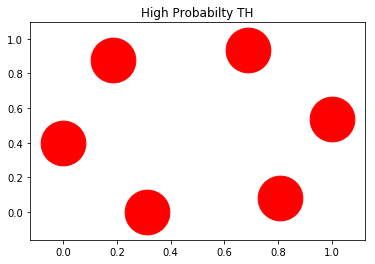

In [25]:
##Plotting the High Probability Model and Low Probability Model 
#%matplotlib inline
a=k2.score(model_1)
b=k2.score(model_2)
c=k2.score(model_3)
d=k2.score(model_4)
e=k2.score(model_5)
        
def plot_network(code,code1):
    plt.figure(1)
    plt.title("High Probabilty TH")
    G1= nx.DiGraph(code)
    nx.draw_networkx(G1,with_labels=True,node_size=2000,font_size=20)
    plt.savefig('High_probablity_TH.jpg')
    plt.figure(2)
    plt.title("Low Probabilty TH")
    G2 =nx.DiGraph(code1)
    nx.draw_networkx(G2,with_labels=True,node_size=2000,fint_size=20)
    plt.savefig('Low_probablity_TH.jpg')
    plt.show()
    
model_list =[a,b,c,d,e]
import numpy as np
index_min = np.argmin(model_list)
index_max = np.argmax(model_list)
c =[None]*2


if(index_min == 0 or index_max == 0):
    if index_min ==0 :
        c[0] =model_1
    else:
        c[1] =model_1
    
if(index_min == 1 or index_max ==1):
    if index_min ==1 :
        c[0] =model_2
        
    else:
        c[1] =model_2
        
if(index_min ==2 or index_max ==2):
    if index_min ==2 :
        c[0] =model_3
    else:
        c[1] = model_3
if(index_min ==3 or index_max ==3):
    if index_min ==3 :
        c[0] = model_4
    else:
        c[1] = model_4
if(index_min ==4 or index_max ==4):
    if index_min ==4 :
        c[0] = model_5
    else:
        c[1] = model_5
        
plot_network(c[0],c[1])

In [26]:
## Local dependencies
print(k2.local_score('x2', parents=['x1']))
print(k2.local_score('x4', parents=['x1']))
print(k2.local_score('x6', parents=['x1']))
print(k2.local_score('x3', parents=['x2']))
print(k2.local_score('x5', parents=['x2']))


-7197.174354825165
-3977.9891324647438
-6981.097087413918
-4120.5159162938435
-6025.127757468963


In [27]:
#from pgmpy.estimators import BayesianEstimator
#est = BayesianEstimator(model_1, data_1)
#print(est.estimate_cpd('x4', prior_type='K2', equivalent_sample_size=10))

# TASK 3

#### CONVERTING BAYSEIAN NETWORK TO MARKOV NETWORK [MORALIZATION]

A:\anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
A:\anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
A:\anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


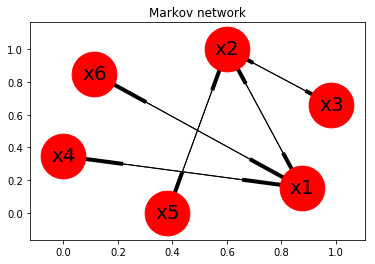

In [28]:
mm = model_1.to_markov_model()

plt.title("Markov network")
Gm= nx.DiGraph(mm)
nx.draw_networkx(Gm,with_labels=True,node_size=2000,font_size=20)
plt.savefig('Markovmodel.jpg')

##### Infering a Query 

In [29]:
## Infering a Query with Variable Elimination
count_B =[]
for i in range(100):
    ## Inference Time of Markov model
    start_m = time.time()
    infer_m = VariableElimination(mm)
    print("The query is:",infer_m.map_query(variables=['x1','x3','x4','x5'],evidence={'x2': 2, 'x6': 0}))
    end_m = time.time()
    print("The time taken to infer is:",(end_m-start_m))
    diff_m = end_m -start_m
    ## Inference time of Bayseian Model
    start_B = time.time()
    infer_B = VariableElimination(model_1)
    print("The query is:",infer_B.map_query(variables=['x1','x3','x4','x5'],evidence={'x2': 2, 'x6': 0}))
    end_B = time.time()
    print("The time taken to infer is: %s"%(end_B-start_B))
    diff_b = end_B -start_m
    if(diff_b>diff_m):
        count_B.append("B")
    elif diff_b < diff_m:
        count_B.append("M")
    else:
        count_B.append("E")

The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03125929832458496
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031245708465576172
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.04686164855957031
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.01562356948852539
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031247377395629883
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031249046325683594
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031247377395629883
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03126120567321777
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.04687094688415527
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031235456466674805
The q

The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03124713897705078
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031248807907104492
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031246423721313477
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031249284744262695
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.015622854232788086
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03124713897705078
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031248807907104492
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03124713897705078
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031247854232788086
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.015624046325683594
The

The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.01562047004699707
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.0
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031246662139892578
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.0
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.015622854232788086
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.0156252384185791
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.015636682510375977
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.01561117172241211
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.015624523162841797
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.015623807907104492
The query is: {'x1': 0, 'x3': 1, 'x4':

In [30]:
from collections import Counter
c_B=Counter(count_B)
print("B is count of Bayesian Network M is count of markov Netork E means that same inference time was taken for both network ")
print(c_B.keys())
print(c_B.values())

B is count of Bayesian Network M is count of markov Netork E means that same inference time was taken for both network 
dict_keys(['B', 'E'])
dict_values([99, 1])


In [31]:
count =[]

In [32]:
## Infering time of bayseian Model using Belief Propagation
## Inference time of Bayseian Model
from pgmpy.inference import BeliefPropagation
for i in range(100):
    start_B = time.time()
    infer_BA = BeliefPropagation(model_1)
    print("The query is:",infer_BA.map_query(variables=['x1','x3','x4','x5'],evidence={'x2': 2, 'x6': 0}))
    end_B = time.time()
    diff_b = end_B-start_B
    print("The time taken to infer is: %s"%(end_B-start_B))
    ## Infering time of bayseian Model using Belief Propagation
    ## Inference time of Markov Model
    start_m = time.time()
    infer_m = BeliefPropagation(mm)
    print("The query is:",infer_BA.map_query(variables=['x1','x3','x4','x5'],evidence={'x2': 2, 'x6': 0}))
    end_m = time.time()
    diff_m = end_m-start_m
    print("The time taken to infer is:",(end_m-start_m))
    if(diff_b>diff_m):
        print("B greater M")
        count.append("B")
    elif diff_b < diff_m:
        print("B less M")
        count.append("M")
    else:
        print("equal")
        count.append("E")
    

The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.07811141014099121
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.0468745231628418
B greater M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.06249570846557617
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.04689359664916992
B greater M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.10936713218688965
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.06247997283935547
B greater M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03124094009399414
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031248092651367188
B less M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.06249642372131348
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time take

The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031246423721313477
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031247615814208984
B less M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.04687190055847168
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031249046325683594
B greater M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031247854232788086
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03124690055847168
B greater M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.04687309265136719
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031248092651367188
B greater M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03124713897705078
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time

The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031246662139892578
B greater M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031245946884155273
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031248807907104492
B less M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031246662139892578
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.046875
B less M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031246185302734375
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03124833106994629
B less M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.03124690055847168
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken to infer is: 0.031247854232788086
B less M
The query is: {'x1': 0, 'x3': 1, 'x4': 0, 'x5': 0}
The time taken 

In [33]:
from collections import Counter
c=Counter(count)
print("B is Bayesian Network M is markov Netork E means that same inference time was taken for both network ")
print(c.keys())
print(c.values())


## generated the count how many times 
## the time Bayesian network is higher than markov network

B is Bayesian Network M is markov Netork E means that same inference time was taken for both network 
dict_keys(['B', 'M'])
dict_values([61, 39])


### ================================================================================

## TASK 4 
#### {Constructing Bayesian Network given the AND Dataset}

In [34]:
# Data Pre-Processing
Data = pd.read_csv("AND-Features.csv")
data = Data.iloc[:,2:]
#data

#### Defining Models

In [42]:
##===== Model 1 using Hill Climb Search ==============
hc = HillClimbSearch(data, scoring_method=K2Score(data))
best_model_HC = hc.estimate()
print("Edges from Hill Climb Search :",best_model_HC.edges())
model_A_1 = BayesianModel(best_model_HC.edges())
print("===Model_1===")
##===== From Model 2 to Model 4 I used Constraint based Estimator which gives me the partial DAG and I completed the DAG
##      with my intution

##======= Defining the Model 2 ==========
model_A_2 = BayesianModel()
model_A_2.add_nodes_from(['f1','f2','f3','f4','f5','f6','f7','f8','f9'])
model_A_2.add_edges_from([('f6', 'f4'), ('f6', 'f1'), 
                        ('f4', 'f3'), ('f4', 'f5'),
                        ('f3', 'f7'), ('f5', 'f7'),
                        ('f5', 'f8'), ('f7', 'f9'),
                        ('f8', 'f9')])
print("===Model_2===")

##======= Defining the Model 3 ==========
model_A_3 = BayesianModel()
model_A_3.add_nodes_from(['f1','f2','f3','f4','f5','f6','f7','f8','f9'])
model_A_3.add_edges_from([('f8', 'f4'), ('f1', 'f8'), 
                        ('f8', 'f9'), ('f4', 'f3'),
                        ('f9', 'f2'), ('f3', 'f5'),
                        ('f5', 'f6')])
print("===Model_3===")

##======= Defining the Model 4 ==========
model_A_4 = BayesianModel()
model_A_4.add_nodes_from(['f1','f2','f3','f4','f5','f6','f7','f8','f9'])
model_A_4.add_edges_from([('f1', 'f3'), ('f3', 'f4'), 
                        ('f3', 'f7'), ('f5', 'f8'),
                        ('f7', 'f9'), ('f8', 'f9'),
                        ('f1', 'f6'), ('f6', 'f2')])
print("===Model_4===")

##====== Defining the Model 5 ===========
model_A_5 = BayesianModel()
model_A_5.add_nodes_from(['f1','f2','f3','f4','f5','f6','f7','f8','f9'])
model_A_5.add_edges_from([('f2', 'f6'), ('f6', 'f8'), 
                        ('f8', 'f1'), ('f1', 'f4'),
                        ('f4', 'f5'),('f1', 'f7'), ('f7', 'f9'),('f3','f4')])
print("===Model_5===")

Edges from Hill Climb Search : [('f3', 'f4'), ('f3', 'f9'), ('f3', 'f8'), ('f5', 'f9'), ('f5', 'f3'), ('f9', 'f8'), ('f9', 'f7'), ('f9', 'f1'), ('f9', 'f6'), ('f9', 'f2'), ('f9', 'f4')]
===Model_1===
===Model_2===
===Model_3===
===Model_4===
===Model_5===


#### Comparing the K2 Score

In [43]:
## Creating a object for k2 class 
k2_A = K2Score(data)

print('Model 1 K2 Score: ' + str(k2_A.score(model_A_1)))
print('Model 2 K2 Score: ' + str(k2_A.score(model_A_2)))
print('Model 3 K2 Score: ' + str(k2_A.score(model_A_3)))
print('Model 4 K2 Score: ' + str(k2_A.score(model_A_4)))
print('Model 5 K2 Score: ' + str(k2_A.score(model_A_5)))


Model 1 K2 Score: -9462.704892371386
Model 2 K2 Score: -9651.205832104775
Model 3 K2 Score: -9650.47769234564
Model 4 K2 Score: -9638.598070845634
Model 5 K2 Score: -9708.834970084605


A:\anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
A:\anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
A:\anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


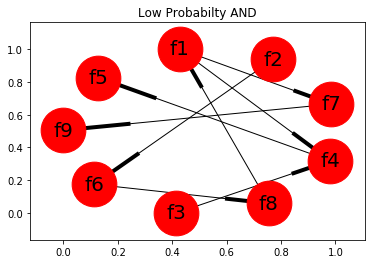

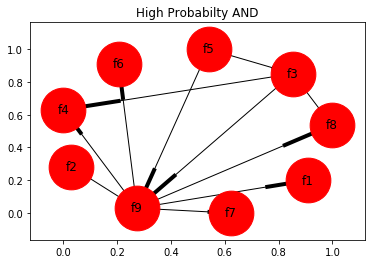

In [44]:
a_A=k2_A.score(model_A_1)
b_A=k2_A.score(model_A_2)
c_A=k2_A.score(model_A_3)
d_A=k2_A.score(model_A_4)
e_A=k2_A.score(model_A_5)

def plot_network_A(code,code1):
    plt.figure(1)
    plt.title("Low Probabilty AND")
    G1= nx.DiGraph(code)
    nx.draw_networkx(G1,with_labels=True,node_size=2000,font_size=20)
    plt.savefig('Low_probablity_AND.jpg')
    plt.figure(2)
    plt.title("High Probabilty AND")
    G2 =nx.DiGraph(code1)
    nx.draw_networkx(G2,with_labels=True,node_size=2000,fint_size=20)
    plt.savefig('High_probablity_AND.jpg')
    plt.show()

model_list =[a_A,b_A,c_A,d_A,e_A]
import numpy as np
index_min = np.argmin(model_list)
index_max = np.argmax(model_list)
c =[None]*2


if(index_min == 0 or index_max == 0):
    if index_min ==0 :
        c[0] =model_A_1
    else:
        c[1] =model_A_1
    
if(index_min == 1 or index_max ==1):
    if index_min ==1 :
        c[0] =model_A_2
        
    else:
        c[1] =model_A_2
        
if(index_min ==2 or index_max ==2):
    if index_min ==2 :
        c[0] =model_A_3
    else:
        c[1] = model_A_3
if(index_min ==3 or index_max ==3):
    if index_min ==3 :
        c[0] = model_A_4
    else:
        c[1] = model_A_4
if(index_min ==4 or index_max ==4):
    if index_min ==4 :
        c[0] = model_A_5
    else:
        c[1] = model_A_5
        
plot_network_A(c[0],c[1])


### Estimating CPD

In [45]:
from pgmpy.estimators import BayesianEstimator
model_A_1.fit(data,estimator=BayesianEstimator,prior_type='K2',equivalent_sample_size=1000)
#est = BayesianEstimator(model_A_1, data)
cpds = model_A_1.get_cpds()
for i in cpds:
    print(i)
    print("#############################")
#print(est.estimate_cpd('f9', prior_type='K2', equivalent_sample_size=1000))

+-------+---------------------+----------------------+----------------------+-------+
| f5    | f5(0)               | f5(1)                | f5(2)                | f5(3) |
+-------+---------------------+----------------------+----------------------+-------+
| f3(0) | 0.20967741935483872 | 0.024390243902439025 | 0.11823899371069183  | 0.125 |
+-------+---------------------+----------------------+----------------------+-------+
| f3(1) | 0.7419354838709677  | 0.9512195121951219   | 0.8528301886792453   | 0.375 |
+-------+---------------------+----------------------+----------------------+-------+
| f3(2) | 0.04838709677419355 | 0.024390243902439025 | 0.028930817610062894 | 0.5   |
+-------+---------------------+----------------------+----------------------+-------+
#############################
+-------+---------------------+----------------------+-------+----------------------+---------------------+---------------------+
| f3    | f3(0)               | f3(0)                | f3(1) | f3(